### Import Dependencies

In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
from torchvision import datasets, transforms, models  # datasets and transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

### Import Dataset

In [ ]:
# Define a sequence of transformations to be applied to the input images:
# - Resize the images to size of 255x255 pixels
# - Center crop the images to size of 224x224 pixels
# - Convert the images to PyTorch tensors
transform = transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])

In [ ]:
# Get dataset
dataset = datasets.ImageFolder("PlantVillage-Dataset/raw/color", transform=transform)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 54305
    Root location: PlantVillage-Dataset/raw/color
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [ ]:
indices = list(range(len(dataset)))

In [ ]:
# Size of training dataset
split = int(np.floor(0.85 * len(dataset)))

In [ ]:
# Size of validation dataset
validation = int(np.floor(0.70 * split))

In [ ]:
print(0, validation, split, len(dataset))

0 32311 46159 54305


In [ ]:
print(f"length of train size :{validation}")
print(f"length of validation size :{split - validation}")
print(f"length of test size :{len(dataset)-validation}")

length of train size :32311
length of validation size :13848
length of test size :21994


In [ ]:
# Shuffle the images
np.random.shuffle(indices)

### Split into Train and Test

In [ ]:
# Get the index ranges
train_indices, validation_indices, test_indices = (indices[:validation], indices[validation:split], indices[split:])

# Create random samplers
train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

targets_size = len(dataset.class_to_idx)

### Creating Model

In [ ]:
# Class for Convolutional Neural Network
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Conv_1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # Conv_2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # Conv_3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # Conv_4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        # Dense layer (last layer)
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)
        # Flatten
        out = out.view(-1, 50176)
        # Fully connected
        out = self.dense_layers(out)
        return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = CNN(targets_size)
model.to(device)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
# Softmax + Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

### Batch Gradient Descent

In [ ]:
# Function for batch gradient descent
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    # Losses on training and validation set in each epoch
    training_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        start = datetime.now()

        # Run model on training set
        training_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)
            training_loss.append(loss.item())
            loss.backward()

            optimizer.step()

        mean_training_loss = np.mean(training_loss)
        training_losses[e] = mean_training_loss

        # Run model on validation set
        validation_loss = []
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)
            validation_loss.append(loss.item())

        mean_validation_loss = np.mean(validation_loss)
        validation_losses[e] = mean_validation_loss

        time_taken = datetime.now() - start

        print(f"Epoch : {e+1}/{epochs}, Training_loss:{mean_training_loss:.3f}, Test_loss:{mean_validation_loss:.3f}, Duration:{time_taken}")

    return training_losses, validation_losses

In [ ]:
batch_size = 64

# Get training set
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

# Get validation set
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

# Get test set
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
# Run Batch Gradient Descent on CNN model
training_losses, validation_losses = batch_gd(model, criterion, train_loader, validation_loader, 5)

Epoch : 1/5, Training_loss:2.119, Test_loss:1.515, Duration:0:04:09.787071
Epoch : 2/5, Training_loss:1.291, Test_loss:1.088, Duration:0:04:11.362036
Epoch : 3/5, Training_loss:0.990, Test_loss:1.127, Duration:0:04:17.571318
Epoch : 4/5, Training_loss:0.822, Test_loss:0.845, Duration:0:04:25.095690
Epoch : 5/5, Training_loss:0.687, Test_loss:0.771, Duration:0:04:30.686242


### Save the Model

In [ ]:
torch.save(model.state_dict() , 'plant_disease_model_1.pt')

### Load Model

In [ ]:
targets_size = 38
model = CNN(targets_size)
model.load_state_dict(torch.load("plant_disease_model_1.pt"))
model.eval()

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

### Plot the loss

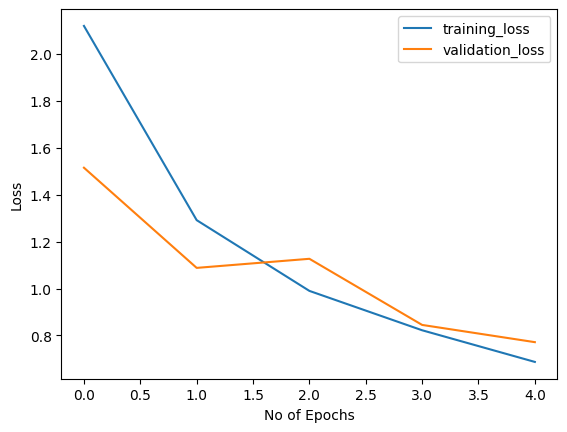

In [ ]:
plt.plot(training_losses, label = 'training_loss')
plt.plot(validation_losses, label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [ ]:
# Function to check accuracy of model on some dataloader
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    last_layer_features = []

    for inputs, targets in loader:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        model.to("cuda")

        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        last_layer_features.append(outputs.cpu().detach().numpy())

        num_correct += (predictions == targets).sum().item()
        num_total += targets.shape[0]

    last_layer_features = np.concatenate(last_layer_features)

    accuracy = num_correct/num_total
    return accuracy, last_layer_features

In [ ]:
# Get the accuracies along with the features of the last layer in the CNN model (to be used in combining CNN with other classifiers)
train_accuracy, last_layer_features_train = accuracy(model, train_loader)
val_accuracy, last_layer_features_val = accuracy(model, validation_loader)
test_accuracy, last_layer_features_test = accuracy(model, test_loader)

print(f"Training accuracy = {train_accuracy}\nTest accuracy = {test_accuracy}\nValidation accuracy = {val_accuracy}")

Training accuracy = 0.9126613227693355
Test accuracy = 0.8853424993862018
Validation accuracy = 0.8830878105141536


### Predicting an image

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

In [ ]:
index_to_disease_transformation = dataset.class_to_idx

# Swapping key and value
index_to_disease_transformation = dict([(value, key) for key, value in index_to_disease_transformation.items()])

index_to_disease_transformation

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
# Function to predict on some image using some model (default set to CNN model created before)
def predict_image(path_to_image, model=model):
    model = model.to(device)

    image = Image.open(path_to_image).resize((224, 224))

    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))

    output = model(input_data)
    output = output.detach().numpy()

    index = np.argmax(output)
    sep = path_to_image.split('/')
    pred_csv = index_to_disease_transformation[index]

    return (pred_csv == sep[3])

In [ ]:
file = open('data.txt')
num_pred = 1000
correct = 0

content = file.readlines()

indices = np.random.choice(np.arange(0, len(content)), replace=False, size=(num_pred))
for i in range(0,num_pred):
  correct += predict_image("PlantVillage-Dataset/"+content[indices[i]][:-1])

print(f"Correct predictions = {correct}\nTotal predictions = {num_pred}")


Predicted:  Potato___Early_blight
Actual:  Potato___Early_blight
********************
Predicted:  Tomato___Tomato_Yellow_Leaf_Curl_Virus
Actual:  Tomato___Tomato_Yellow_Leaf_Curl_Virus
********************
Predicted:  Peach___Bacterial_spot
Actual:  Apple___Apple_scab
********************
Predicted:  Corn_(maize)___Northern_Leaf_Blight
Actual:  Corn_(maize)___Northern_Leaf_Blight
********************
Predicted:  Apple___Black_rot
Actual:  Apple___Black_rot
********************
Predicted:  Cherry_(including_sour)___Powdery_mildew
Actual:  Cherry_(including_sour)___Powdery_mildew
********************
Predicted:  Grape___Black_rot
Actual:  Grape___Black_rot
********************
Predicted:  Corn_(maize)___Common_rust_
Actual:  Corn_(maize)___Common_rust_
********************
Predicted:  Soybean___healthy
Actual:  Soybean___healthy
********************
Predicted:  Tomato___healthy
Actual:  Tomato___healthy
********************
Predicted:  Orange___Haunglongbing_(Citrus_greening)
Actual:  Or

# Image preprocessing along with various ML models

In [ ]:
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.3 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py

In [ ]:
images_per_class = 800
fixed_size = tuple((500, 500))
train_path = "dataset/train"
h5_train_data = 'output/train_data.h5'
h5_train_labels = 'output/train_labels.h5'
bins = 8

In [ ]:
# Converting each image to RGB from BGR format

def rgb_bgr(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img

In [ ]:
# Conversion to HSV image format from RGB

def bgr_hsv(rgb_img):
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv_img

In [ ]:
# Image segmentation to extract green and brown color

def img_segmentation(rgb_img,hsv_img):
    lower_green = np.array([25,0,20])
    upper_green = np.array([100,255,255])

    healthy_mask = cv2.inRange(hsv_img, lower_green, upper_green)
    result = cv2.bitwise_and(rgb_img,rgb_img, mask=healthy_mask)

    lower_brown = np.array([10,0,10])
    upper_brown = np.array([30,255,255])

    disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
    disease_result = cv2.bitwise_and(rgb_img, rgb_img, mask=disease_mask)

    final_mask = healthy_mask + disease_mask
    final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)

    return final_result

In [ ]:
# 1st Feature descriptor => Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
# 2nd Feature descriptor => Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

In [ ]:
# 3rd Feature descriptor => Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [67]:
# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels = []

['.ipynb_checkpoints', 'diseased', 'healthy']


In [74]:
# loop over the training data sub-folders
for training_name in train_labels[1:]:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    for x in range(1,images_per_class+1):
        # get the image file name
        file = dir + "/" + str(x) + ".jpg"

        # read the image and resize it to a fixed-size
        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        # Running Function Bit By Bit
        RGB_BGR = rgb_bgr(image)
        BGR_HSV = bgr_hsv(RGB_BGR)
        IMG_SEGMENT = img_segmentation(RGB_BGR,BGR_HSV)

        # Call for Global Feature Descriptors
        fv_hu_moments = fd_hu_moments(IMG_SEGMENT)
        fv_haralick = fd_haralick(IMG_SEGMENT)
        fv_histogram = fd_histogram(IMG_SEGMENT)

        # Concatenate
        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        # update the list of labels and feature vectors
        labels.append(current_label)
        global_features.append(global_feature)

In [75]:
# get the overall feature vector size
print(f"Feature vector size = {np.array(global_features).shape}")
# get the overall training label size
print(f"Training label size = {np.array(labels).shape}")

Feature vector size = (1600, 532)
Training label size = (1600,)


In [78]:
# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)

In [79]:
# scale features in the range (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler            = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [80]:
print(f"Target labels: {target}")
print(f"Target labels shape: {target.shape}")

Target labels: [0 0 0 ... 1 1 1]
Target labels shape: (1600,)


In [82]:
# save the feature vector using HDF5
h5f_data = h5py.File(h5_train_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

<HDF5 dataset "dataset_1": shape (1600, 532), type "<f8">

In [83]:
h5f_label = h5py.File(h5_train_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

<HDF5 dataset "dataset_1": shape (1600,), type "<i8">

In [84]:
h5f_data.close()
h5f_label.close()

# Model Training

In [85]:
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib

warnings.filterwarnings('ignore')

# Tunable parameters
num_trees = 100
test_size = 0.20
seed = 9
train_path = "dataset/train"
test_path = "dataset/test"
h5_train_data = 'output/train_data.h5'
h5_train_labels = 'output/train_labels.h5'
scoring = "accuracy"

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names = []

# import the feature vector and trained labels
h5f_data = h5py.File(h5_train_data, 'r')
h5f_label = h5py.File(h5_train_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# Verify the shape of the feature vector and labels
print(f"Features shape: {global_features.shape}")
print(f"Labels shape: {global_labels.shape}")

Features shape: (1600, 532)
Labels shape: (1600,)


In [88]:
# Split the training and testing data
trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal = train_test_split(np.array(global_features), np.array(global_labels), test_size=test_size, random_state=seed)

print(f"Train data shape : {trainDataGlobal.shape}")
print(f"Test data shape : {testDataGlobal.shape}")

Train data shape : (1280, 532)
Test data shape : (320, 532)


In [89]:
trainDataGlobal

array([[0.97973956, 0.        , 0.        , ..., 0.01058888, 0.12693628,
        0.96573219],
       [0.90470961, 0.03308547, 0.03047729, ..., 0.01058886, 0.12692807,
        0.96573214],
       [0.92166131, 0.01766604, 0.03559807, ..., 0.01058994, 0.12737134,
        0.96573262],
       ...,
       [0.77039234, 0.        , 0.        , ..., 0.01058886, 0.12693296,
        0.96573218],
       [0.96965597, 0.        , 0.        , ..., 0.01058989, 0.1271198 ,
        0.96574232],
       [0.98389776, 0.19183335, 0.15462199, ..., 0.01058898, 0.12695993,
        0.96573136]])

LR: 0.919531 (0.020978)
LDA: 0.904687 (0.024156)
KNN: 0.922656 (0.030748)
CART: 0.917188 (0.031484)
RF: 0.955469 (0.019469)
NB: 0.855469 (0.021608)
SVM: 0.915625 (0.022317)


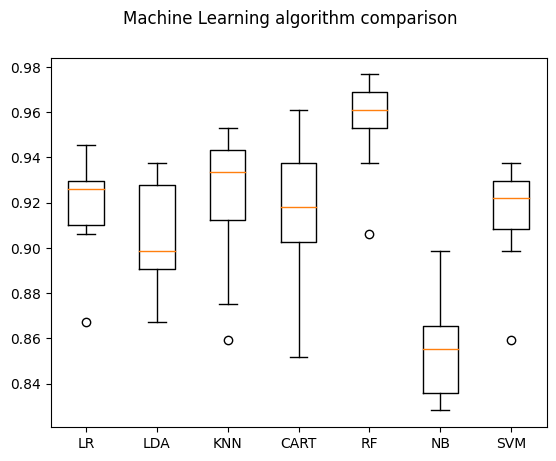

In [91]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [92]:
clf = RandomForestClassifier(n_estimators=num_trees, random_state=seed)
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(random_state=9)

In [93]:
y_predict = clf.predict(testDataGlobal)
y_predict

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,

In [94]:
cm = confusion_matrix(testLabelsGlobal,y_predict)

<Axes: >

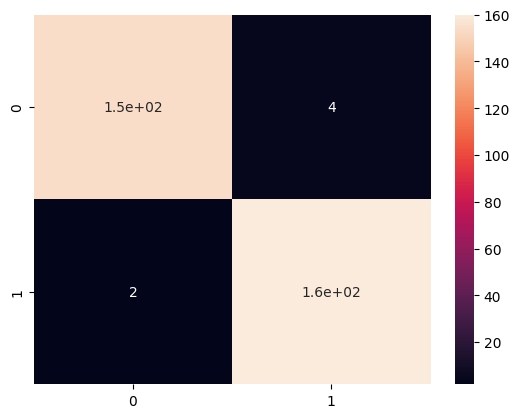

In [95]:
import seaborn as sns
sns.heatmap(cm ,annot=True)

In [96]:
print(classification_report(testLabelsGlobal,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       158
           1       0.98      0.99      0.98       162

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(testLabelsGlobal, y_predict)

0.98125